## Imports

In [1]:
import copy
import pickle
import sys
import tempfile
import uuid
from pathlib import Path

import tqdm

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

In [2]:
submission_path = Path("../XTXStarterKit/").as_posix()
if submission_path not in sys.path:
    sys.path.insert(0, submission_path)

In [3]:
import python.utils
import python.model

In [4]:
pd.set_option("max_columns", 10000)
pd.set_option("max_rows", 10000)

cpu = torch.device("cpu")

In [5]:
%load_ext autoreload
%autoreload 2

## Parameters

In [6]:
try:
    NOTEBOOK_PATH
    UNIQUE_PATH
except NameError:
    NOTEBOOK_PATH = Path("train_residual_tconv").resolve()
    NOTEBOOK_PATH.mkdir(exist_ok=True)
    unique_id = uuid.uuid4().hex[:8]
    UNIQUE_PATH = NOTEBOOK_PATH.joinpath(unique_id)
    UNIQUE_PATH.mkdir()
NOTEBOOK_PATH, UNIQUE_PATH

(PosixPath('/home/kimlab1/strokach/workspace/2019-xtx-forecasting-challenge/notebooks/train_residual_tconv'),
 PosixPath('/home/kimlab1/strokach/workspace/2019-xtx-forecasting-challenge/notebooks/train_residual_tconv/232ee787'))

In [7]:
device = torch.device("cuda:0")

## Workspace

In [8]:
!ls ../data/

data-training.csv.gz


### Load data

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


askRate0  askRate1  askRate2  askRate3  askRate4  askRate5  askRate6  \
0    1619.5    1620.0    1621.0       NaN       NaN       NaN       NaN   
1    1619.5    1620.0    1621.0    1621.5       NaN       NaN       NaN   

   askRate7  askRate8  askRate9  askRate10  askRate11  askRate12  askRate13  \
0       NaN       NaN       NaN        NaN        NaN        NaN        NaN   
1       NaN       NaN       NaN        NaN        NaN        NaN        NaN   

   askRate14  bidRate0  bidRate1  bidRate2  bidRate3  bidRate4  bidRate5  \
0        NaN    1615.0    1614.0    1613.0    1612.0    1611.0    1610.0   
1        NaN    1615.0    1614.0    1613.0    1612.0    1611.0    1610.0   

   bidRate6  bidRate7  bidRate8  bidRate9  bidRate10  bidRate11  bidRate12  \
0    1607.0    1606.0    1605.0    1604.0     1603.0     1602.0     1601.5   
1    1607.0    1606.0    1605.0    1604.0     1603.0     1602.0     1601.5   

   bidRate13  bidRate14  askSize0  askSize1  askSize2  askSize3  askSize4  \
0     1601.0     1600.0       1.0      10.0      24.0       NaN       NaN   
1     1601.0     1600.0       1.0      10.0      24.0       5.0       NaN   

   askSize5  askSize6  askSize7  askSize8  askSize9  askSize10  askSize11  \
0       NaN       NaN       NaN       NaN       NaN        NaN        NaN   
1       NaN       NaN       NaN       NaN       NaN        NaN        NaN   

   askSize12  askSize13  askSize14  bidSize0  bidSize1  bidSize2  bidSize3  \
0        NaN        NaN        NaN       7.0      10.0       1.0      10.0   
1        NaN        NaN        NaN       7.0      10.0       1.0      10.0   

   bidSize4  bidSize5  bidSize6  bidSize7  bidSize8  bidSize9  bidSize10  \
0      20.0       3.0      20.0      27.0      11.0      14.0       35.0   
1      20.0       3.0      20.0      27.0      11.0      14.0       35.0   

   bidSize11  bidSize12  bidSize13  bidSize14    y  
0       10.0        1.0       10.0       13.0 -0.5  
1       10.0        1.0       10.0       13.0 -0.5

2999999


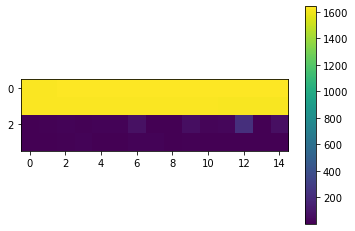

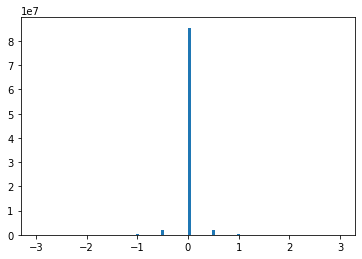

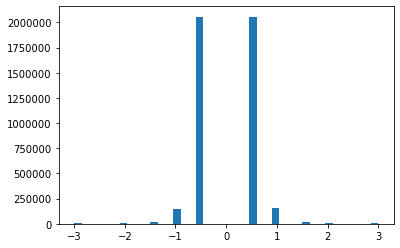

askRate0  askRate1  askRate2  askRate3  askRate4  askRate5  askRate6  \
1       0.0       0.0       0.0       0.5       0.5       0.5       0.5   
2       0.0       0.0       0.0       0.0       0.5       0.5       0.5   

   askRate7  askRate8  askRate9  askRate10  askRate11  askRate12  askRate13  \
1       0.5       0.5       0.5        0.5        0.5        0.5        0.5   
2       0.5       0.5       0.5        0.5        0.5        0.5        0.5   

   askRate14  bidRate0  bidRate1  bidRate2  bidRate3  bidRate4  bidRate5  \
1        0.5       0.0       0.0       0.0       0.0       0.0       0.0   
2        0.5       0.0       0.0       0.0       0.0       0.0       0.0   

   bidRate6  bidRate7  bidRate8  bidRate9  bidRate10  bidRate11  bidRate12  \
1       0.0       0.0       0.0       0.0        0.0        0.0        0.0   
2       0.0       0.0       0.0       0.0        0.0        0.0        0.0   

   bidRate13  bidRate14  askSize0  askSize1  askSize2  askSize3  askSize4  \
1        0.0        0.0       0.0  0.353524  0.487938  0.247103  0.000000   
2        0.0        0.0       0.0  0.353524  0.487938  0.247103  0.106421   

   askSize5  askSize6  askSize7  askSize8  askSize9  askSize10  askSize11  \
1       0.0       0.0       0.0       0.0       0.0        0.0        0.0   
2       0.0       0.0       0.0       0.0       0.0        0.0        0.0   

   askSize12  askSize13  askSize14  bidSize0  bidSize1  bidSize2  bidSize3  \
1        0.0        0.0        0.0  0.298763  0.353524       0.0  0.353524   
2        0.0        0.0        0.0  0.298763  0.353524       0.0  0.353524   

   bidSize4  bidSize5  bidSize6  bidSize7  bidSize8  bidSize9  bidSize10  \
1  0.459946  0.168674  0.459946  0.506022  0.368158  0.405184   0.545866   
2  0.459946  0.168674  0.459946  0.506022  0.368158  0.405184   0.545866   

   bidSize11  bidSize12  bidSize13  bidSize14    y  
1   0.353524        0.0   0.353524   0.393806 -0.5  
2   0.353524        0.0   0.353524   0.393806 -0.5

2999998


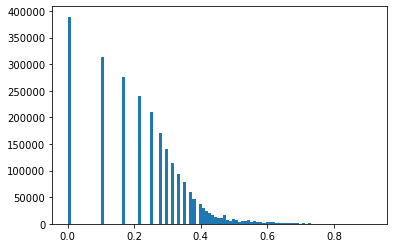

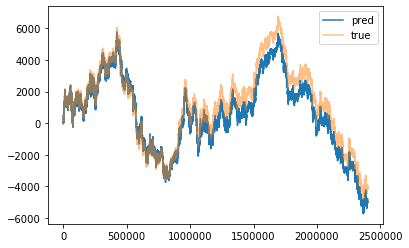

In [9]:
try:
    with Path(tempfile.gettempdir()).joinpath(NOTEBOOK_PATH.name, "train_data_3b.pkl").open("rb") as fin:
        TRAIN_TEST_SPLITS = pickle.load(fin)
except FileNotFoundError:
    %run prepare_training_data_3.ipynb
    temp_data_path = Path(tempfile.gettempdir()).joinpath(NOTEBOOK_PATH.name)
    temp_data_path.mkdir(exist_ok=True)
    with temp_data_path.joinpath("train_data_3b.pkl").open("wb") as fout:
        pickle.dump(TRAIN_TEST_SPLITS, fout, pickle.HIGHEST_PROTOCOL)

In [10]:
train_df, valid_df = TRAIN_TEST_SPLITS[-1]

In [11]:
train_df.head()

askRate0  askRate1  askRate2  askRate3  askRate4  askRate5  askRate6  \
1       0.0       0.0       0.0       0.5       0.5       0.5       0.5   
2       0.0       0.0       0.0       0.0       0.5       0.5       0.5   
3       0.0       0.0       0.0       0.0       0.0       0.0       0.0   
4       0.0       0.0       0.0       0.0       0.0       0.0       0.0   
5       0.0       0.0       0.0       0.0       0.0       0.0       0.0   

   askRate7  askRate8  askRate9  askRate10  askRate11  askRate12  askRate13  \
1       0.5       0.5       0.5        0.5        0.5        0.5        0.5   
2       0.5       0.5       0.5        0.5        0.5        0.5        0.5   
3       0.0       0.0       0.0        0.0        0.0        0.0        0.0   
4       0.0       0.0       0.0        0.0        0.0        0.0        0.0   
5       0.0       0.0       0.0        0.0        0.0        0.0        0.0   

   askRate14  bidRate0  bidRate1  bidRate2  bidRate3  bidRate4  bidRate5  \
1        0.5       0.0       0.0       0.0       0.0       0.0       0.0   
2        0.5       0.0       0.0       0.0       0.0       0.0       0.0   
3        0.0       0.0       0.0       0.0       0.0       0.0       0.0   
4        0.0       0.0       0.0       0.0       0.0       0.0       0.0   
5        0.0       0.0       0.0       0.0       0.0       0.0       0.0   

   bidRate6  bidRate7  bidRate8  bidRate9  bidRate10  bidRate11  bidRate12  \
1       0.0       0.0       0.0       0.0        0.0        0.0        0.0   
2       0.0       0.0       0.0       0.0        0.0        0.0        0.0   
3       0.0       0.0       0.0       0.0        0.0        0.0        0.0   
4       0.0       0.0       0.0       0.0        0.0        0.0        0.0   
5       0.0       0.0       0.0       0.0        0.0        0.0        0.0   

   bidRate13  bidRate14  askSize0  askSize1  askSize2  askSize3  askSize4  \
1        0.0        0.0       0.0  0.353524  0.487938  0.247103  0.000000   
2        0.0        0.0       0.0  0.353524  0.487938  0.247103  0.106421   
3        0.0        0.0       0.0  0.353524  0.487938  0.247103  0.474579   
4        0.0        0.0       0.0  0.353524  0.487938  0.247103  0.532107   
5        0.0        0.0       0.0  0.353524  0.487938  0.247103  0.771335   

   askSize5  askSize6  askSize7  askSize8  askSize9  askSize10  askSize11  \
1       0.0       0.0       0.0       0.0       0.0        0.0        0.0   
2       0.0       0.0       0.0       0.0       0.0        0.0        0.0   
3       0.0       0.0       0.0       0.0       0.0        0.0        0.0   
4       0.0       0.0       0.0       0.0       0.0        0.0        0.0   
5       0.0       0.0       0.0       0.0       0.0        0.0        0.0   

   askSize12  askSize13  askSize14  bidSize0  bidSize1  bidSize2  bidSize3  \
1        0.0        0.0        0.0  0.298763  0.353524       0.0  0.353524   
2        0.0        0.0        0.0  0.298763  0.353524       0.0  0.353524   
3        0.0        0.0        0.0  0.298763  0.353524       0.0  0.353524   
4        0.0        0.0        0.0  0.298763  0.353524       0.0  0.353524   
5        0.0        0.0        0.0  0.298763  0.353524       0.0  0.353524   

   bidSize4  bidSize5  bidSize6  bidSize7  bidSize8  bidSize9  bidSize10  \
1  0.459946  0.168674  0.459946  0.506022  0.368158  0.405184   0.545866   
2  0.459946  0.168674  0.459946  0.506022  0.368158  0.405184   0.545866   
3  0.459946  0.168674  0.459946  0.506022  0.368158  0.405184   0.545866   
4  0.459946  0.168674  0.459946  0.506022  0.368158  0.405184   0.545866   
5  0.459946  0.168674  0.459946  0.506022  0.368158  0.405184   0.545866   

   bidSize11  bidSize12  bidSize13  bidSize14    y  
1   0.353524        0.0   0.353524   0.393806 -0.5  
2   0.353524        0.0   0.353524   0.393806 -0.5  
3   0.353524        0.0   0.353524   0.393806 -0.5  
4   0.353524        0.0   0.353524   0.393806 -0.5  
5   0.353524        0.0   0.353524

### Define model

In [12]:
%%file {UNIQUE_PATH}/model.py
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset


class XTXDataset(Dataset):
    max_values = None

    def __init__(self, data, num_previous=1, mode="train") -> None:
        super().__init__()
        assert num_previous > 0
        #         self.values = (
        #             data[:, :-1].reshape(data.shape[0], 2, 30).transpose([1, 2, 0]).copy()
        #         )
        self.values = np.hstack([data[:, 0:1], data[:, 15:16]]).copy()
        self.targets = data[:, -1:].copy()
        self.num_previous = num_previous
        self.mode = mode

    def __len__(self):
        if self.mode == "train":
            return self.targets.shape[0] // self.num_previous - 1
        else:
            return self.targets.shape[0] - self.num_previous + 1

    def __getitem__(self, index):
        if self.mode == "train":
            offset = np.random.randint(0, self.num_previous - 1)
            step = self.num_previous
        else:
            offset = 0
            step = 1

        start = offset + index * step
        stop = start + self.num_previous

        #         values = self.values[:, :, start:stop]
        values = self.values[start:stop, :]
        targets = self.targets[start:stop, :]

        return values, targets


class XTXModel(nn.Module):
    def __init__(self, input_size, output_size, num_previous, dropout):
        super().__init__()
        self.layer1 = nn.Sequential(
            #
            nn.Conv1d(input_size, 10, kernel_size=181, stride=1, padding=90),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Conv1d(10, output_size, kernel_size=3, stride=1, padding=1),
        )

    def forward(self, x):
        x = x.transpose(1, 2)
        x = (x[:, 0:1, :] + x[:, 1:2, :]) / 2
        x = self.layer1(x)
        x = x.transpose(2, 1)
        return x


def _get_clones(module, N):
    return nn.ModuleList([copy.deepcopy(module) for i in range(N)])

Writing /home/kimlab1/strokach/workspace/2019-xtx-forecasting-challenge/notebooks/train_residual_tconv/232ee787/model.py


In [13]:
%run {UNIQUE_PATH}/model.py

### Train model

In [14]:
batch_size = 600
num_previous = 1000
dropout = 0.5

In [15]:
train_dataset = XTXDataset(train_df.astype(np.float32).values, num_previous, mode="train")
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
print(len(train_dataset))

valid_dataset = XTXDataset(valid_df.astype(np.float32).values, num_previous, mode="train")
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
print(len(valid_dataset))

2398
599


In [16]:
net = XTXModel(1, 1, kernel_sizes=kernel_sizes, num_previous=num_previous, dropout=dropout).to(device)
criterion = nn.MSELoss()
optimizer = optim.AdamW(net.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[3, 6], gamma=0.1)

NameError: name 'kernel_sizes' is not defined

In [ ]:
num_back = 10 + 80
end_offset = sum(kz - 1 for kz in kernel_sizes) - num_back
start_offset = sum(kz - 1 for kz in kernel_sizes) - end_offset

zero_pad_start = torch.zeros(batch_size, max(0, start_offset), 1).to(device)
zero_pad_x = torch.zeros(batch_size, end_offset, 1).to(device)
zero_pad_end = torch.zeros(batch_size, end_offset, 1).to(device)

for epoch in range(400):
    net.train()
    train_losses = []
    for i, batch in enumerate(train_loader):
        x, y = batch
        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad()
        x_in = x
        x_out = net(x_in)
        loss = criterion(x_out, y)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
    print(f"{sum(train_losses) / len(train_losses):.4f}", end=" ")
    train_loss = sum(train_losses) / len(train_losses)

    if (epoch + 1) % 10 == 0:
        net.eval()
        valid_losses = []
        valid_mid_losses = []
        valid_start_losses = []
        valid_end_losses = []
        valid_last_losses = []
        valid_scores = []
        for i, batch in enumerate(valid_loader):
            x, y = batch
            x = x.to(device)
            y = y.to(device)

            x_in = x
            with torch.no_grad():
                x_out = net(x_in)
            loss = criterion(x_out, y)
            loss_mid = criterion(
                x_out[:, end_offset:-end_offset], y[:, end_offset:-end_offset]
            )
            loss_start = criterion(x_out[:, :end_offset], y[:, :end_offset])
            loss_stop = criterion(x_out[:, -end_offset:], y[:, -end_offset:])
            loss_last = criterion(x_out[:, -1:], y[:, -1:])
            score = 1 - ((y[:, -1, :] - x_out[:, -1, :]) ** 2).sum() / (y[:, -1, :] ** 2).sum()
            valid_losses.append(loss.item())
            valid_mid_losses.append(loss_mid.item())
            valid_start_losses.append(loss_start.item())
            valid_end_losses.append(loss_stop.item())
            valid_last_losses.append(loss_last.item())
            valid_scores.append(score)
        print(
            "    "
            f"{sum(valid_losses) / len(valid_losses):.4f} {sum(valid_mid_losses) / len(valid_mid_losses):.4f} "
            f"{sum(valid_start_losses) / len(valid_start_losses):.4f} {sum(valid_end_losses) / len(valid_end_losses):.4f} "
            f"{sum(valid_last_losses) / len(valid_last_losses):.4f} {sum(valid_scores) / len(valid_scores):.4f}"
        )

In [ ]:
end_offset

In [ ]:
0.5456 0.5425 0.5461 0.5477 0.5410 0.5405 0.5418 0.5356 0.5395 0.5380     0.3546 0.3562 0.3503 0.3441 0.3497 -0.0042
0.5304 0.5386 0.5399 0.5340 0.5306 0.5261 0.5301 0.5287 0.5243 0.5216     0.3351 0.3359 0.3297 0.3336 0.3491 -0.0022
0.5043 0.4953 0.4874 0.4819 0.4655 0.4481 0.4310 0.4073 0.3944 0.3680     0.2193 0.2138 0.2070 0.2827 0.3691 -0.0598
0.3474 0.3229 0.3000 0.2795 0.2572 0.2353 0.2166 0.1976 0.1800 0.1632     0.0708 0.0585 0.0554 0.1996 0.3618 -0.0388
0.1521 0.1377 0.1297 0.1232 0.1181 0.1134 0.1132 0.1100 0.1078 0.1073     0.0343 0.0204 0.0195 0.1779 0.3514 -0.0088
0.1039 0.1017 0.1015 0.1011 0.0978 0.0971 0.0969 0.0954 0.0939 0.0923     0.0314 0.0172 0.0164 0.1772 0.3519 -0.0103
0.0914 0.0921 0.0895 0.0894 0.0881 0.0867 0.0864 0.0834 0.0826 0.0813     0.0279 0.0135 0.0128 0.1763 0.3530 -0.0134
0.0845 0.0814 0.0817 0.0809 0.0797 0.0779 0.0767 0.0770 0.0761 0.0751     0.0243 0.0096 0.0091 0.1749 0.3534 -0.0147
0.0750 0.0747 0.0725 0.0746 0.0734 0.0726 0.0721 0.0720 0.0725 0.0714     0.0216 0.0068 0.0065 0.1737 0.3528 -0.0130
0.0701 0.0694 0.0696 0.0690 0.0697 0.0687 0.0688 0.0677 0.0698 0.0674     0.0203 0.0053 0.0051 0.1736 0.3526 -0.0125
0.0670 0.0678 0.0655 0.0689 0.0668 0.0677 0.0660 0.0680 0.0668 0.0675     0.0196 0.0045 0.0044 0.1736 0.3529 -0.0132
0.0647 0.0656 0.0655 0.0642 0.0659 0.0658 0.0651 0.0671 0.0643 0.0672     0.0192 0.0042 0.0041 0.1737 0.3533 -0.0143
0.0640 0.0652 0.0647 0.0640 0.0660 0.0648 0.0639 0.0650 0.0648 0.0647     0.0190 0.0039 0.0038 0.1736 0.3535 -0.0150
0.0648 0.0647 0.0652 0.0641 0.0647 0.0635 0.0662 0.0641 0.0645 0.0663     0.0188 0.0037 0.0037 0.1737 0.3539 -0.0163
0.0648 0.0637 0.0635 0.0643 0.0641 0.0631 0.0639 0.0636 0.0638 0.0647     0.0188 0.0036 0.0036 0.1737 0.3543 -0.0172
0.0639 0.0649 0.0643 0.0623 0.0622 0.0649 0.0620 0.0645 0.0621 0.0638     0.0187 0.0035 0.0035 0.1737 0.3545 -0.0179
0.0624 0.0634 0.0623 0.0632 0.0649 0.0642 0.0645 0.0643 0.0650 0.0631     0.0187 0.0035 0.0035 0.1740 0.3552 -0.0199
0.0622 0.0655 0.0649 0.0634 0.0643 0.0636 0.0640 0.0632 0.0615 0.0637     0.0186 0.0034 0.0034 0.1740 0.3556 -0.0210
0.0632 0.0634 0.0635 0.0639 0.0635 0.0629 0.0626 0.0636 0.0632 0.0615     0.0186 0.0034 0.0034 0.1739 0.3558 -0.0216
0.0627 0.0644 0.0644 0.0650 0.0642 0.0639 0.0630 0.0635 0.0641 0.0630     0.0186 0.0034 0.0034 0.1740 0.3561 -0.0223
